In [3]:
import os
from pathlib import Path
import re

In [6]:
import h5py
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from river import evaluate
from river import metrics
from river import tree
from sklearn.decomposition import PCA

In [76]:
data_path = Path('datacompletos_sin_escalar.mat')

# new_data = scipy.io.loadmat(file, appendmat=False)
# fields = scipy.io.whosmat(data_file) # NotImplementedError: Please use HDF reader for matlab v7.3 files, e.g. h5py

data = []

with h5py.File(data_path, 'r') as data_file:
    data_all = data_file['datacompleto']
    # print(data.shape)
    # (58008, 5740) -> 2417 × 24 = 58008 points per exp., 5740 experiments as in ECCOMAS paper
    # 2460 healthy experiments
    # 820 x 4 damaged experiments (4 different damage types)
    # Each exp is 9.789s @ 275Hz -> 2417 time instants (× 24 accelerometers = 58008 points)
    # print(data.dtype) # float64
    # print(len(data_all[:, 0])) -> 58008
    # print(len(data_all[0, :])) -> 5740 okay it just doesn't like two indices in a row [x][y], instead use [x, y]

    # Let's take a sample consisting of only a handful of partial experiments. This is just to
    # quickly iterate new code without shuffling around a gig of data.
    cutoff = 3000
    # Take just 10 healthy experiments
    for i in range(10):
        data.append({"class": "healthy", "original_index": i, "data": np.array(data_all[i, :cutoff])})
    # And 5 each of the failure modes
    for i in range(2460, 5740, 82):
        data.append({"class": "unhealthy", "original_index": i, "data": np.array(data_all[i, :cutoff])})
        # TODO: preserve actual class
    # This is assuming they're ordered just like that, which they might not. Take this into account when looking at
    # trial run results.

In [77]:
len(data[0]['data'])

3000

In [112]:
# Data unfolding... not sure if the paper did any pre-processing here such as scaling
rows = []
for exp in data:
    # Collapse sample into a single row like:
    # s0_t0,s0_t1,s0_t2,...s0_tn,s1_t0,s1_t1,s1_t2,...
    # Already done in our data, so just some type shuffling
    row = pd.DataFrame(exp['data']).transpose()
    # Flag so we remember which dataset this sample belonged to. We'll need to
    # exclude it when operating on the data.
    row.insert(0, 'original_index', exp['original_index'])
    row.insert(0, 'class', exp['class'])
    rows.append(row)
# Build DataFrame from all the rows
unfolded = pd.concat(rows)
# Shuffle the rows
unfolded = unfolded.sample(frac=1, random_state=1)

In [113]:
unfolded

,class,original_index,0,1,2,3,4,5,6,7,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
0,unhealthy,3854,0.000352,0.000336,0.000349,0.000283,0.000391,0.000374,0.000411,0.000392,...,0.000219,0.000365,0.000372,0.000196,0.000537,0.000113,0.000375,0.000339,0.000503,0.000350
0,unhealthy,4510,0.000347,0.000358,0.000390,0.000318,0.000290,0.000294,0.000354,0.000366,...,0.000257,0.000247,0.000258,0.000319,0.000144,0.000462,0.000385,0.000229,0.000210,0.000373
0,unhealthy,4920,0.000313,0.000300,0.000353,0.000351,0.000365,0.000371,0.000293,0.000360,...,0.000310,0.000558,0.000347,0.000219,0.000375,0.000241,0.000305,0.000273,0.000410,0.000321
0,unhealthy,4756,0.000335,0.000333,0.000379,0.000382,0.000380,0.000310,0.000288,0.000351,...,0.000332,0.000340,0.000354,0.000175,0.000259,0.000304,0.000541,0.000159,0.000283,0.000271
0,healthy,2,0.000160,0.000142,0.000226,0.000219,0.000144,0.000218,0.000216,0.000265,...,0.000207,0.000250,0.000058,0.000593,0.000195,0.000003,0.000351,0.000243,0.000280,0.000147
0,healthy,3,0.000199,0.000232,0.000203,0.000219,0.000202,0.000248,0.000220,0.000175,...,0.000071,0.000425,0.000140,0.000520,0.000075,0.000118,0.000265,0.000222,0.000021,0.000362
0,unhealthy,5576,0.000331,0.000288,0.000351,0.000317,0.000343,0.000267,0.000342,0.000309,...,0.000409,0.000255,0.000252,0.000377,0.000236,0.000398,0.000249,0.000514,0.000263,0.000294
0,unhealthy,4018,0.000371,0.000350,0.000310,0.000341,0.000320,0.000316,0.000291,0.000313,...,0.000183,0.000420,0.000282,0.000233,0.000220,0.000375,0.000448,0.000484,0.000113,0.000432
0,unhealthy,5412,0.000304,0.000338,0.000317,0.000352,0.000310,0.000339,0.000376,0.000278,...,0.000252,0.000359,0.000322,0.000374,0.000224,0.000476,0.000351,0.000443,0.000152,0.000659
0,unhealthy,4182,0.000326,0.000360,0.000302,0.000360,0.000302,0.000333,0.000377,0.000336,...,0.000286,0.000444,0.000287,0.000285,0.000508,0.000262,0.000236,0.000297,0.000233,0.000486


In [115]:
# PCA fitting
pca = PCA(n_components=8)
pca.fit(unfolded.iloc[:,2:]) # excludes class label column
print(sum(pca.explained_variance_ratio_))
print(pca.singular_values_)

0.5697147582382464
[0.02045133 0.01341318 0.01323349 0.01287754 0.01279237 0.01167335
 0.01128495 0.00915379]


In [116]:
samples_pca = pca.transform(unfolded.iloc[:,2:])

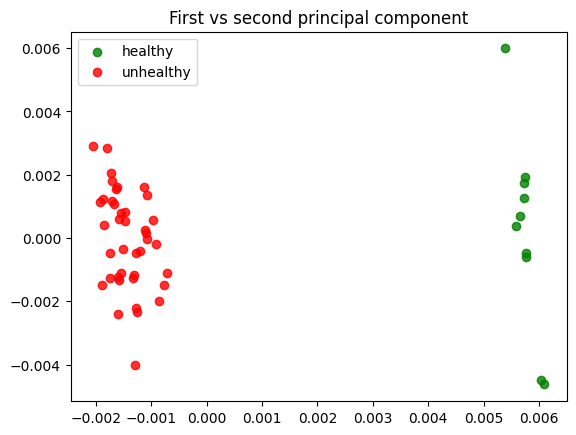

In [117]:
plt.figure()
for color, dataset in zip(['green', 'red'], ['healthy', 'unhealthy']):
    plt.scatter(
        samples_pca[unfolded['class'] == dataset, 0], samples_pca[unfolded['class'] == dataset, 1], color=color, alpha=0.8, label=dataset
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("First vs second principal component")
plt.show()

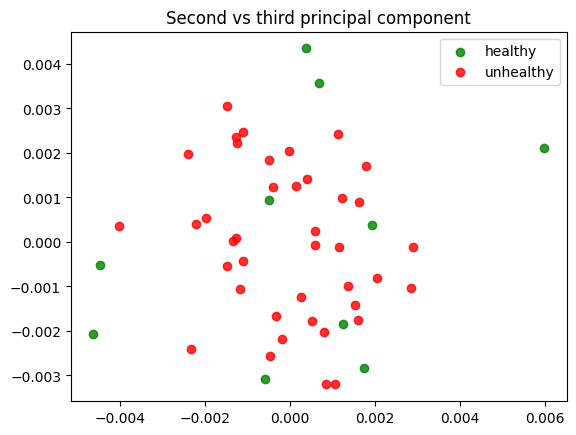

In [118]:
plt.figure()
for color, dataset in zip(['green', 'red'], ['healthy', 'unhealthy']):
    plt.scatter(
        samples_pca[unfolded['class'] == dataset, 1], samples_pca[unfolded['class'] == dataset, 2], color=color, alpha=0.8, label=dataset
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("Second vs third principal component")
plt.show()
# Looks like a frog